In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
    bart_toggle_data_callback,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from sklearn.decomposition import PCA

set_rc()

bart_plot_colors = {0: 'deep red', 
                    1: 'orange', 
                    2: 'goldenrod',
                    3: 'gray',
                    4: 'pink'}

In [ ]:
# GRU Params
# [ih, hh, ib, hb]
# ih, hh have shape [3*n, m]
#  where n is the number of GRU units and m is the input to the layer
# for hh, row i are inputs to the node i%n
#  e.g., in a 64 dim GRU
#  row 0 has reset weights for node 0, row 64 has update weights for node 0
#  row 1 has reset weights for node 1, row 65 has update weights for node 1

In [2]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/full/full_wait_0/120.pt')
# res = evalu(model, obs_rms)
# res = reshape_parallel_evalu_res(res, meta_balloons=100)
# plot_1colornfsize(res)

In [89]:
%run model_evaluation

In [90]:
fix_conditions = []
for c in [0, 1, 2, 3, 4]:
    for delay in [0, 1, 2, 3, 4]:
        fix_conditions.append({
            'color': c,
            'delay': delay,
            'passive': False
        })
for c in [0, 1, 2]:
    for delay in [0, 1, 2, 3, 4]:
        fix_conditions.append({
            'color': c,
            'delay': delay,
            'passive': True
        })
env_kwargs = {'fix_conditions': fix_conditions}
evalu = partial(forced_action_evaluate, data_callback=bart_toggle_data_callback,
                env_name='BartEnv', num_episodes=40,
                env_kwargs=env_kwargs,
                seed=1,
                deterministic=True,)
                # random_init_rnn_hxs=True)

In [91]:
res = evalu(model, obs_rms)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\envs\registration.py:521: UserWarning: WARN: Using the latest versioned environment `BartEnv-v0` instead of the unversioned environment `BartEnv`.
  logger.warn(


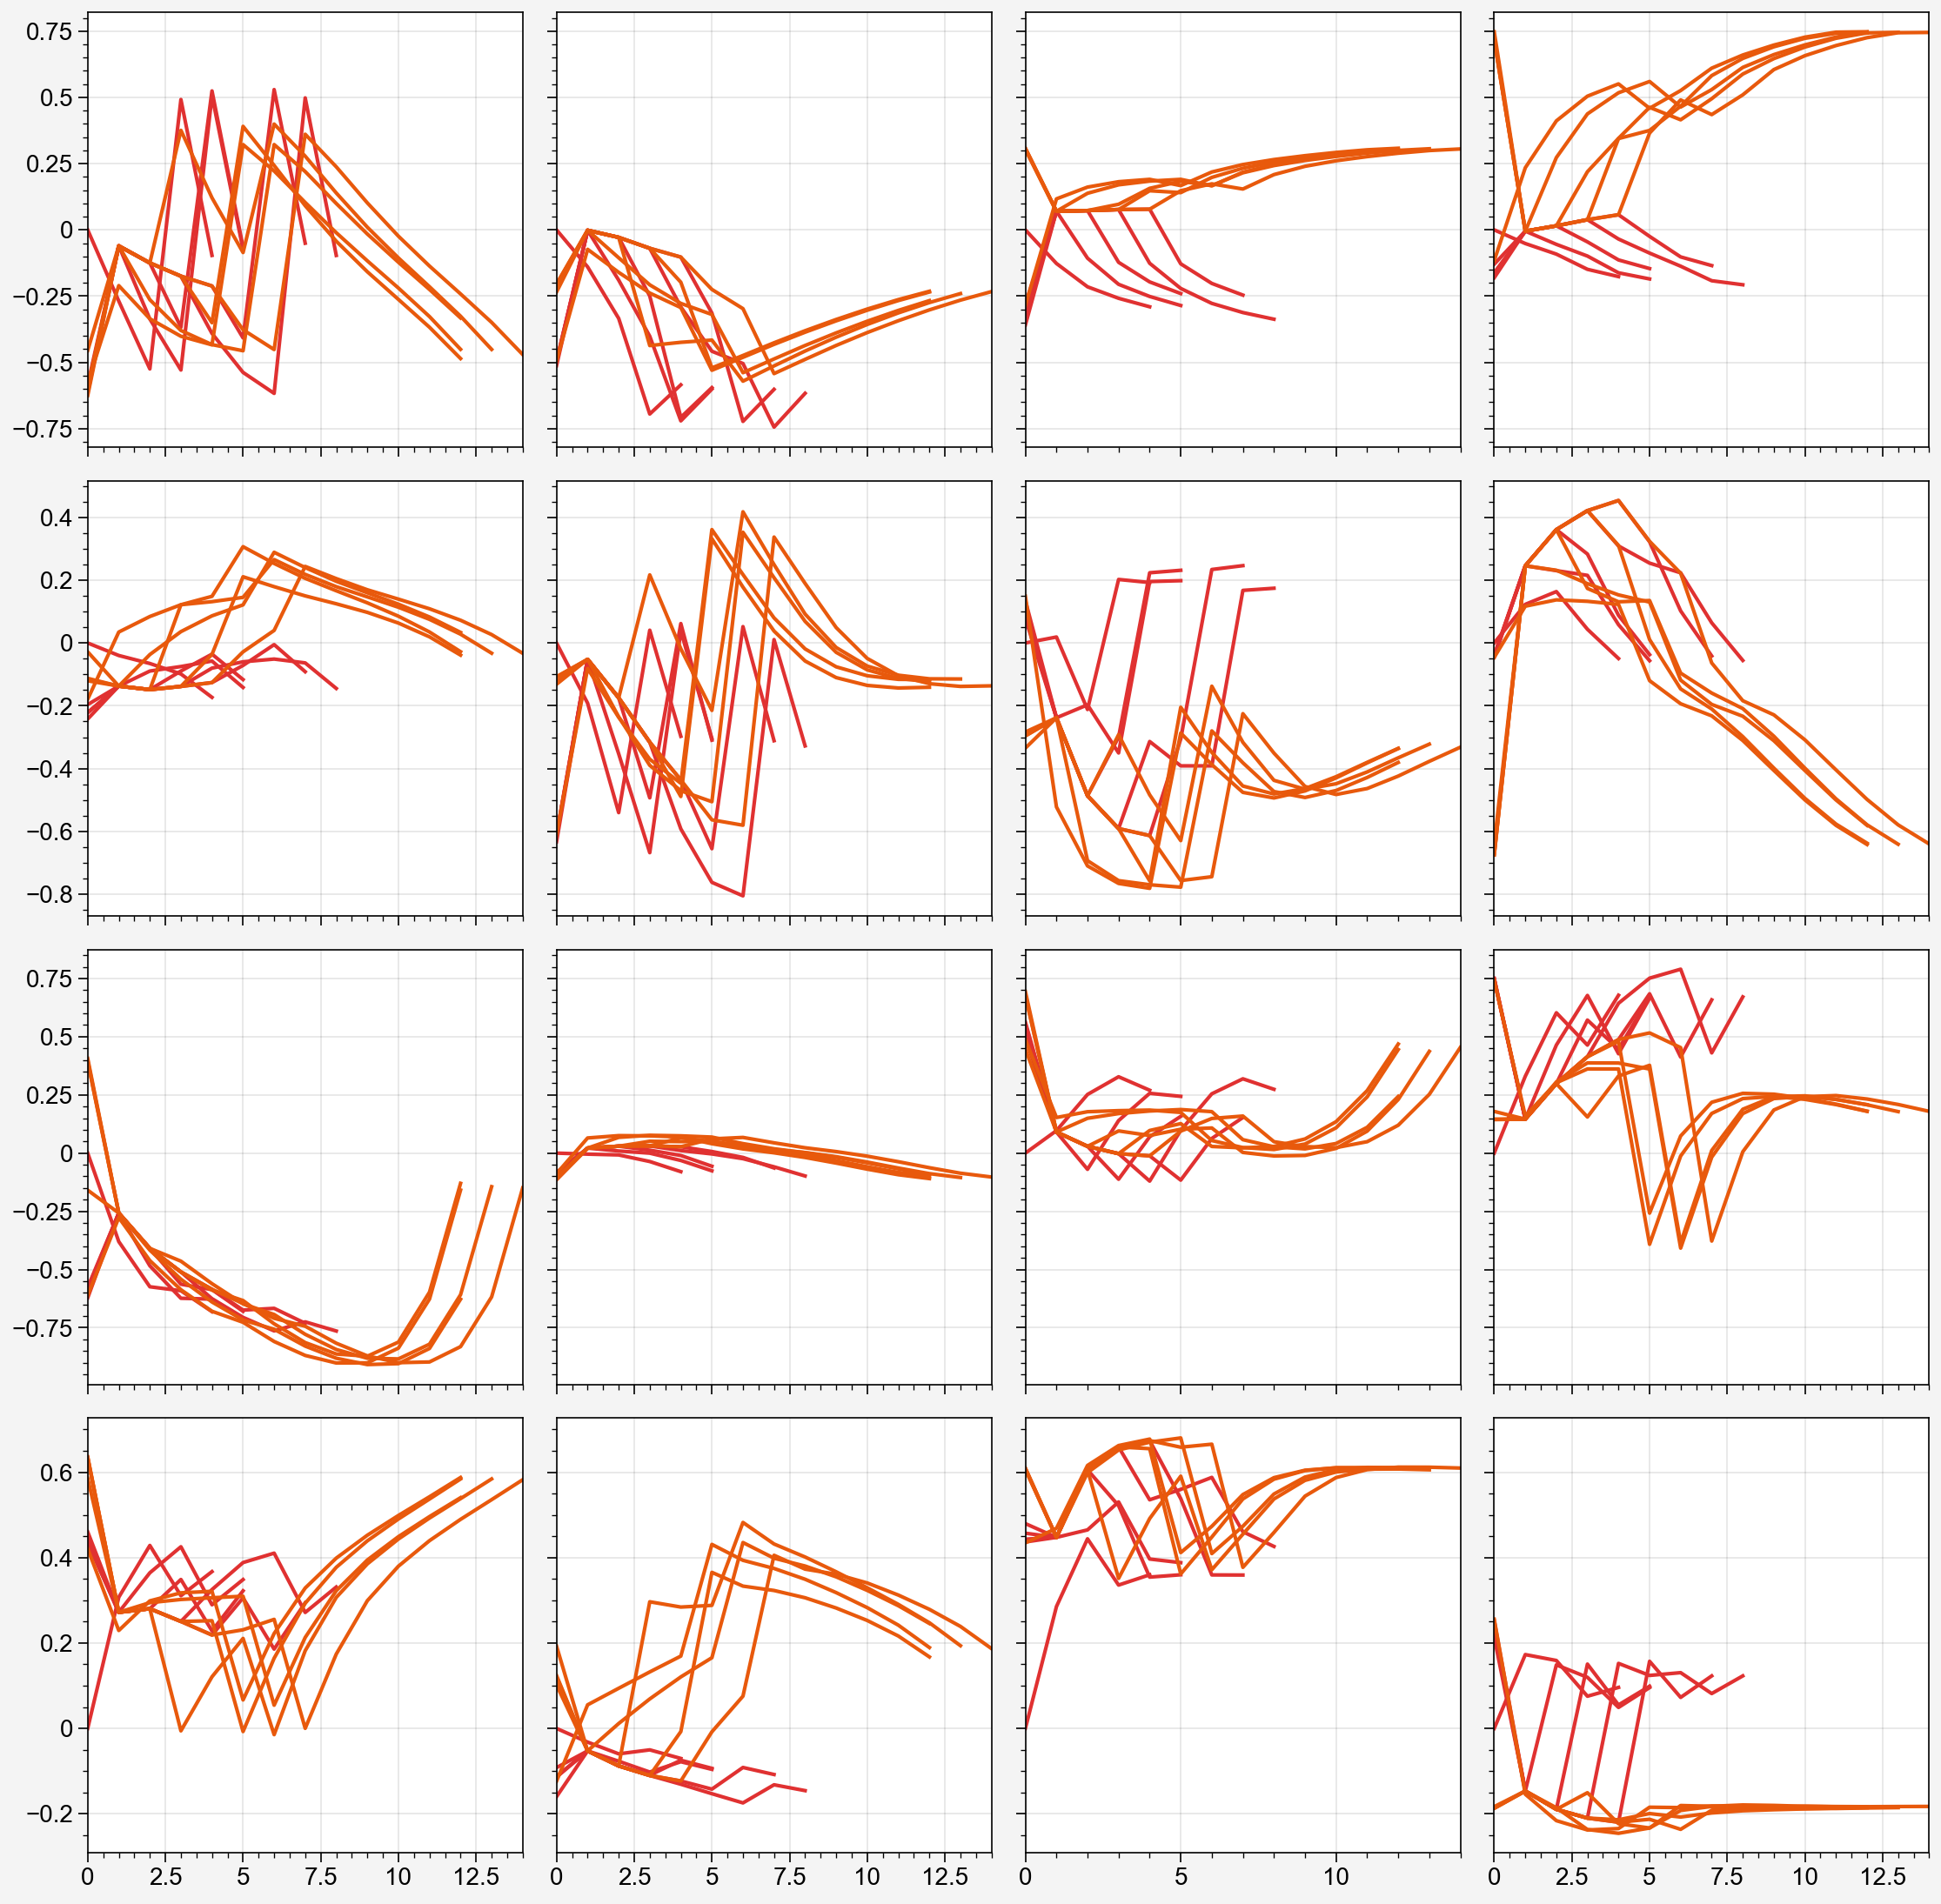

In [164]:
fig, ax = pplt.subplots(nrows=4, ncols=4)

for i in range(5):
    rnn_hxs = res['rnn_hxs'][i]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c='red8')

for i in range(5):
    rnn_hxs = res['rnn_hxs'][i+5]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c='orange8')

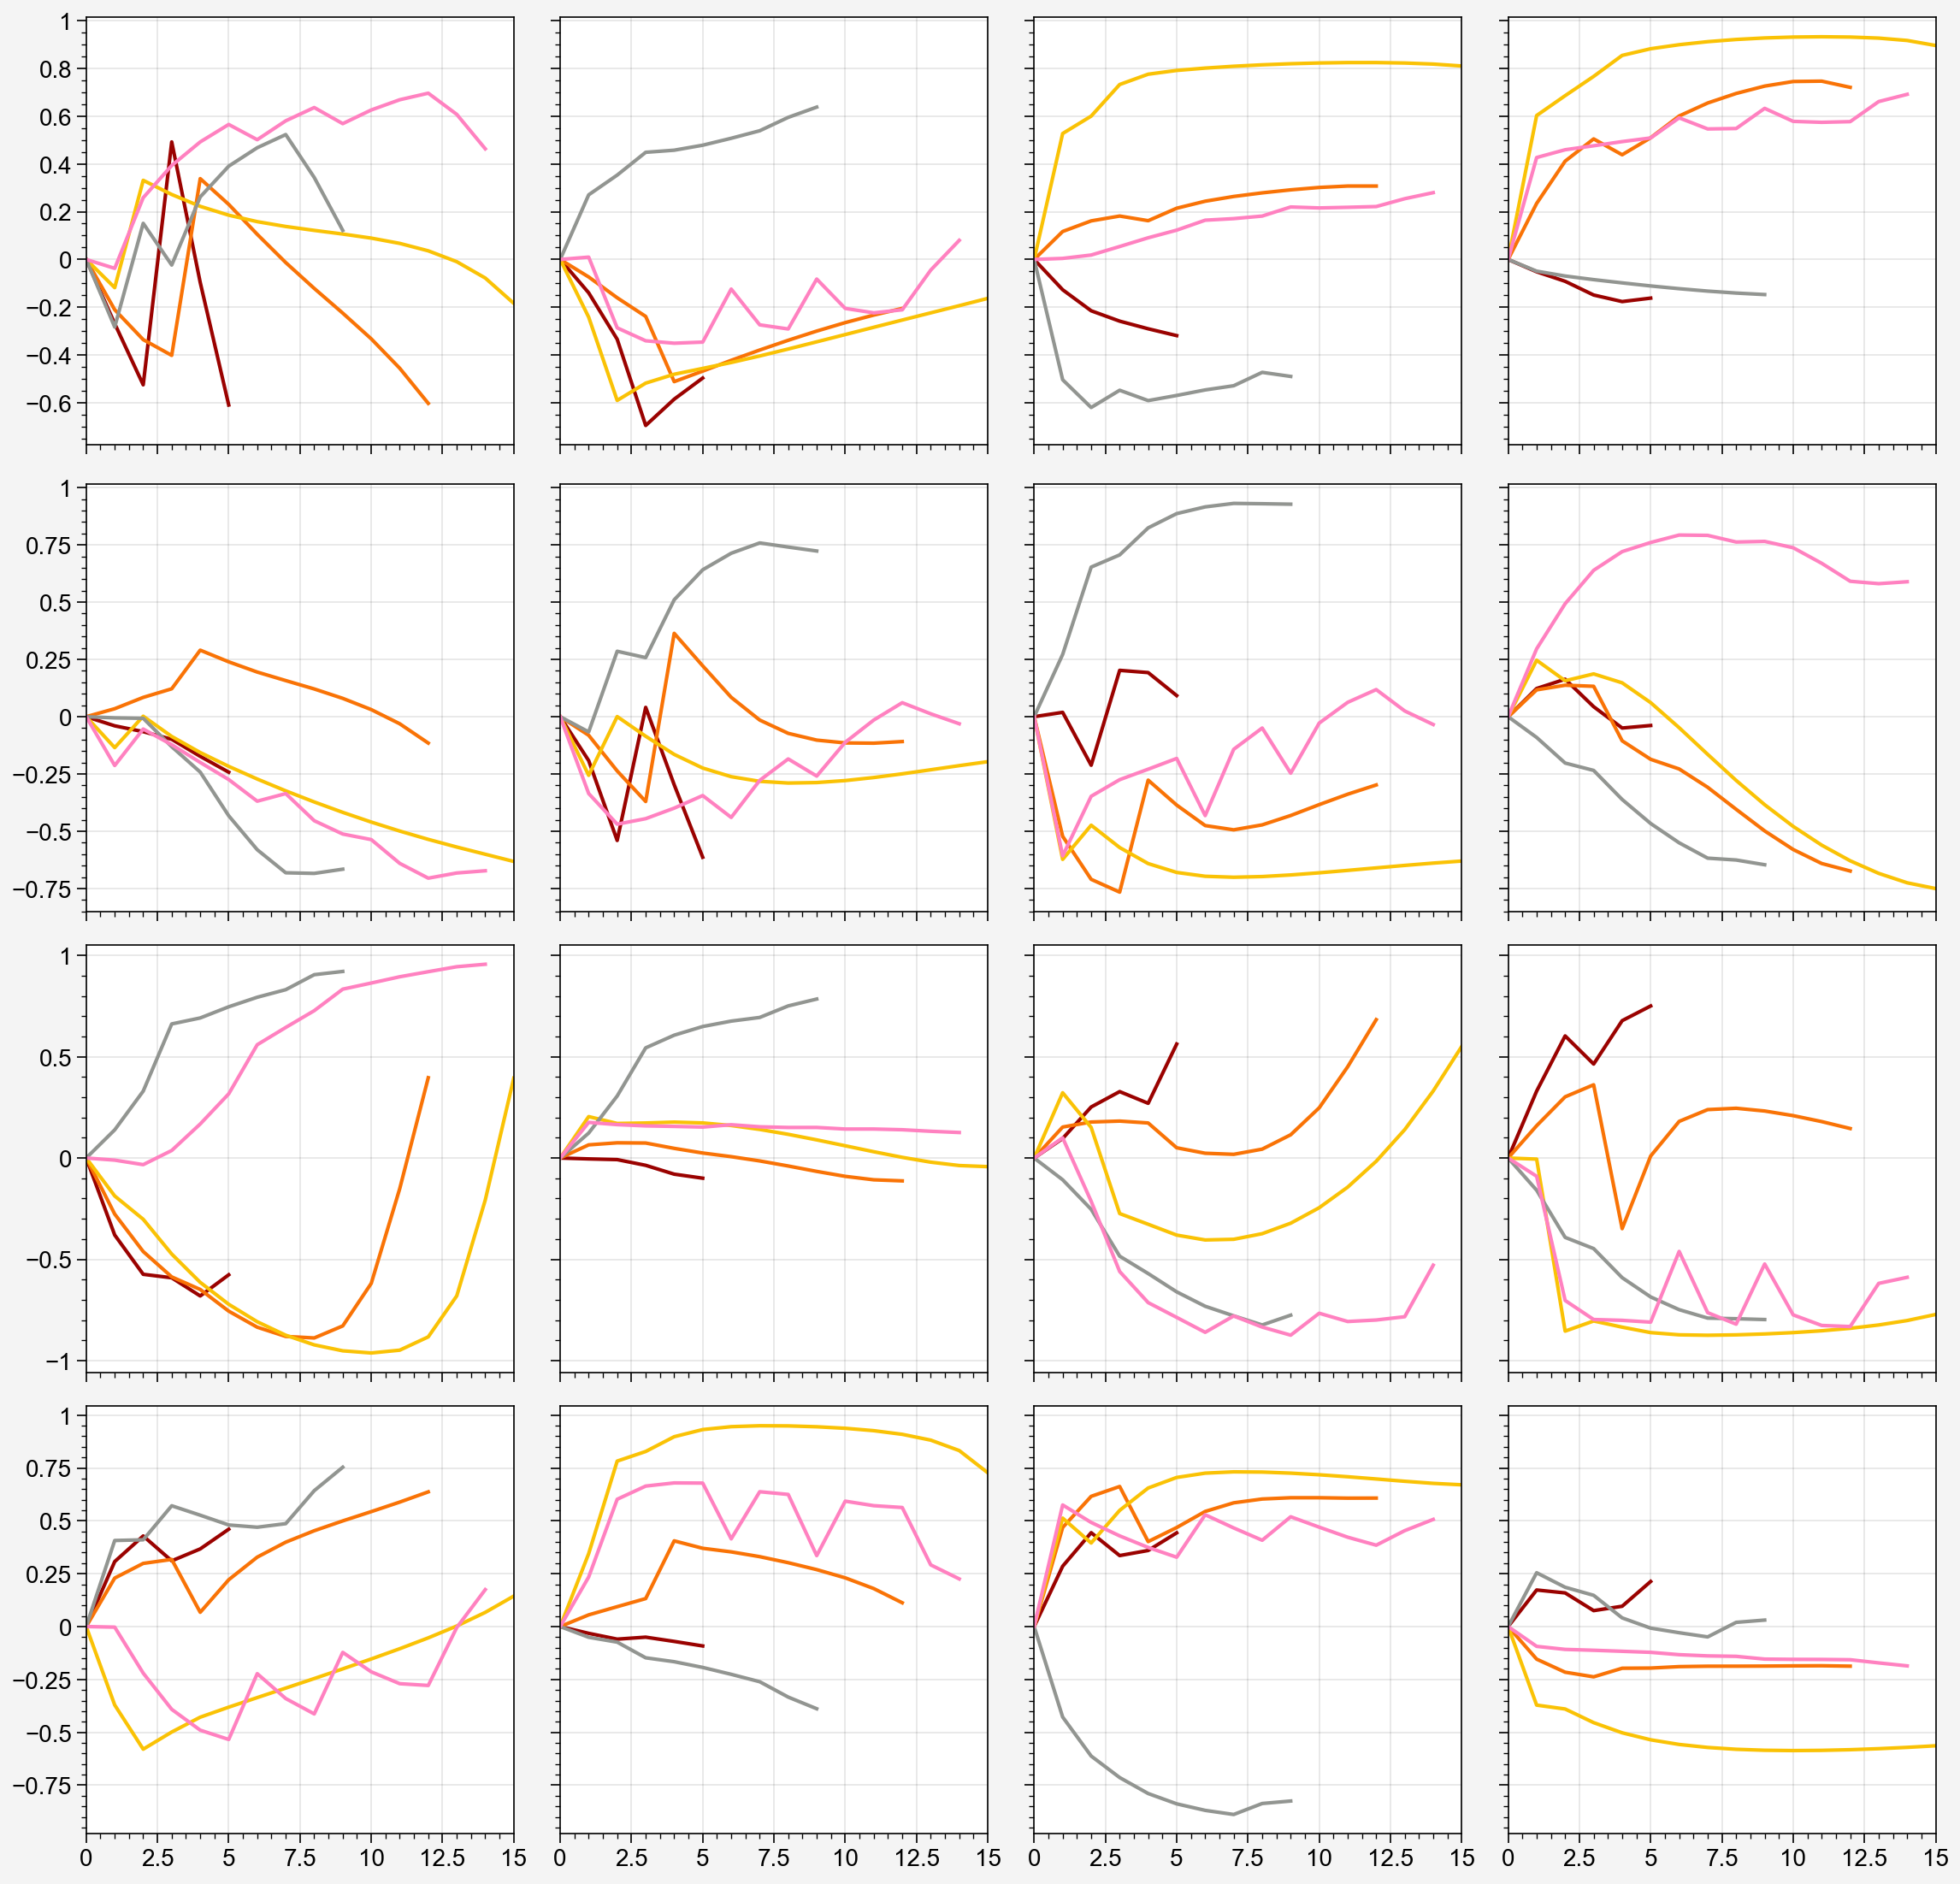

In [10]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    rnn_hxs = res['rnn_hxs'][i*5]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c=bart_plot_colors[i])


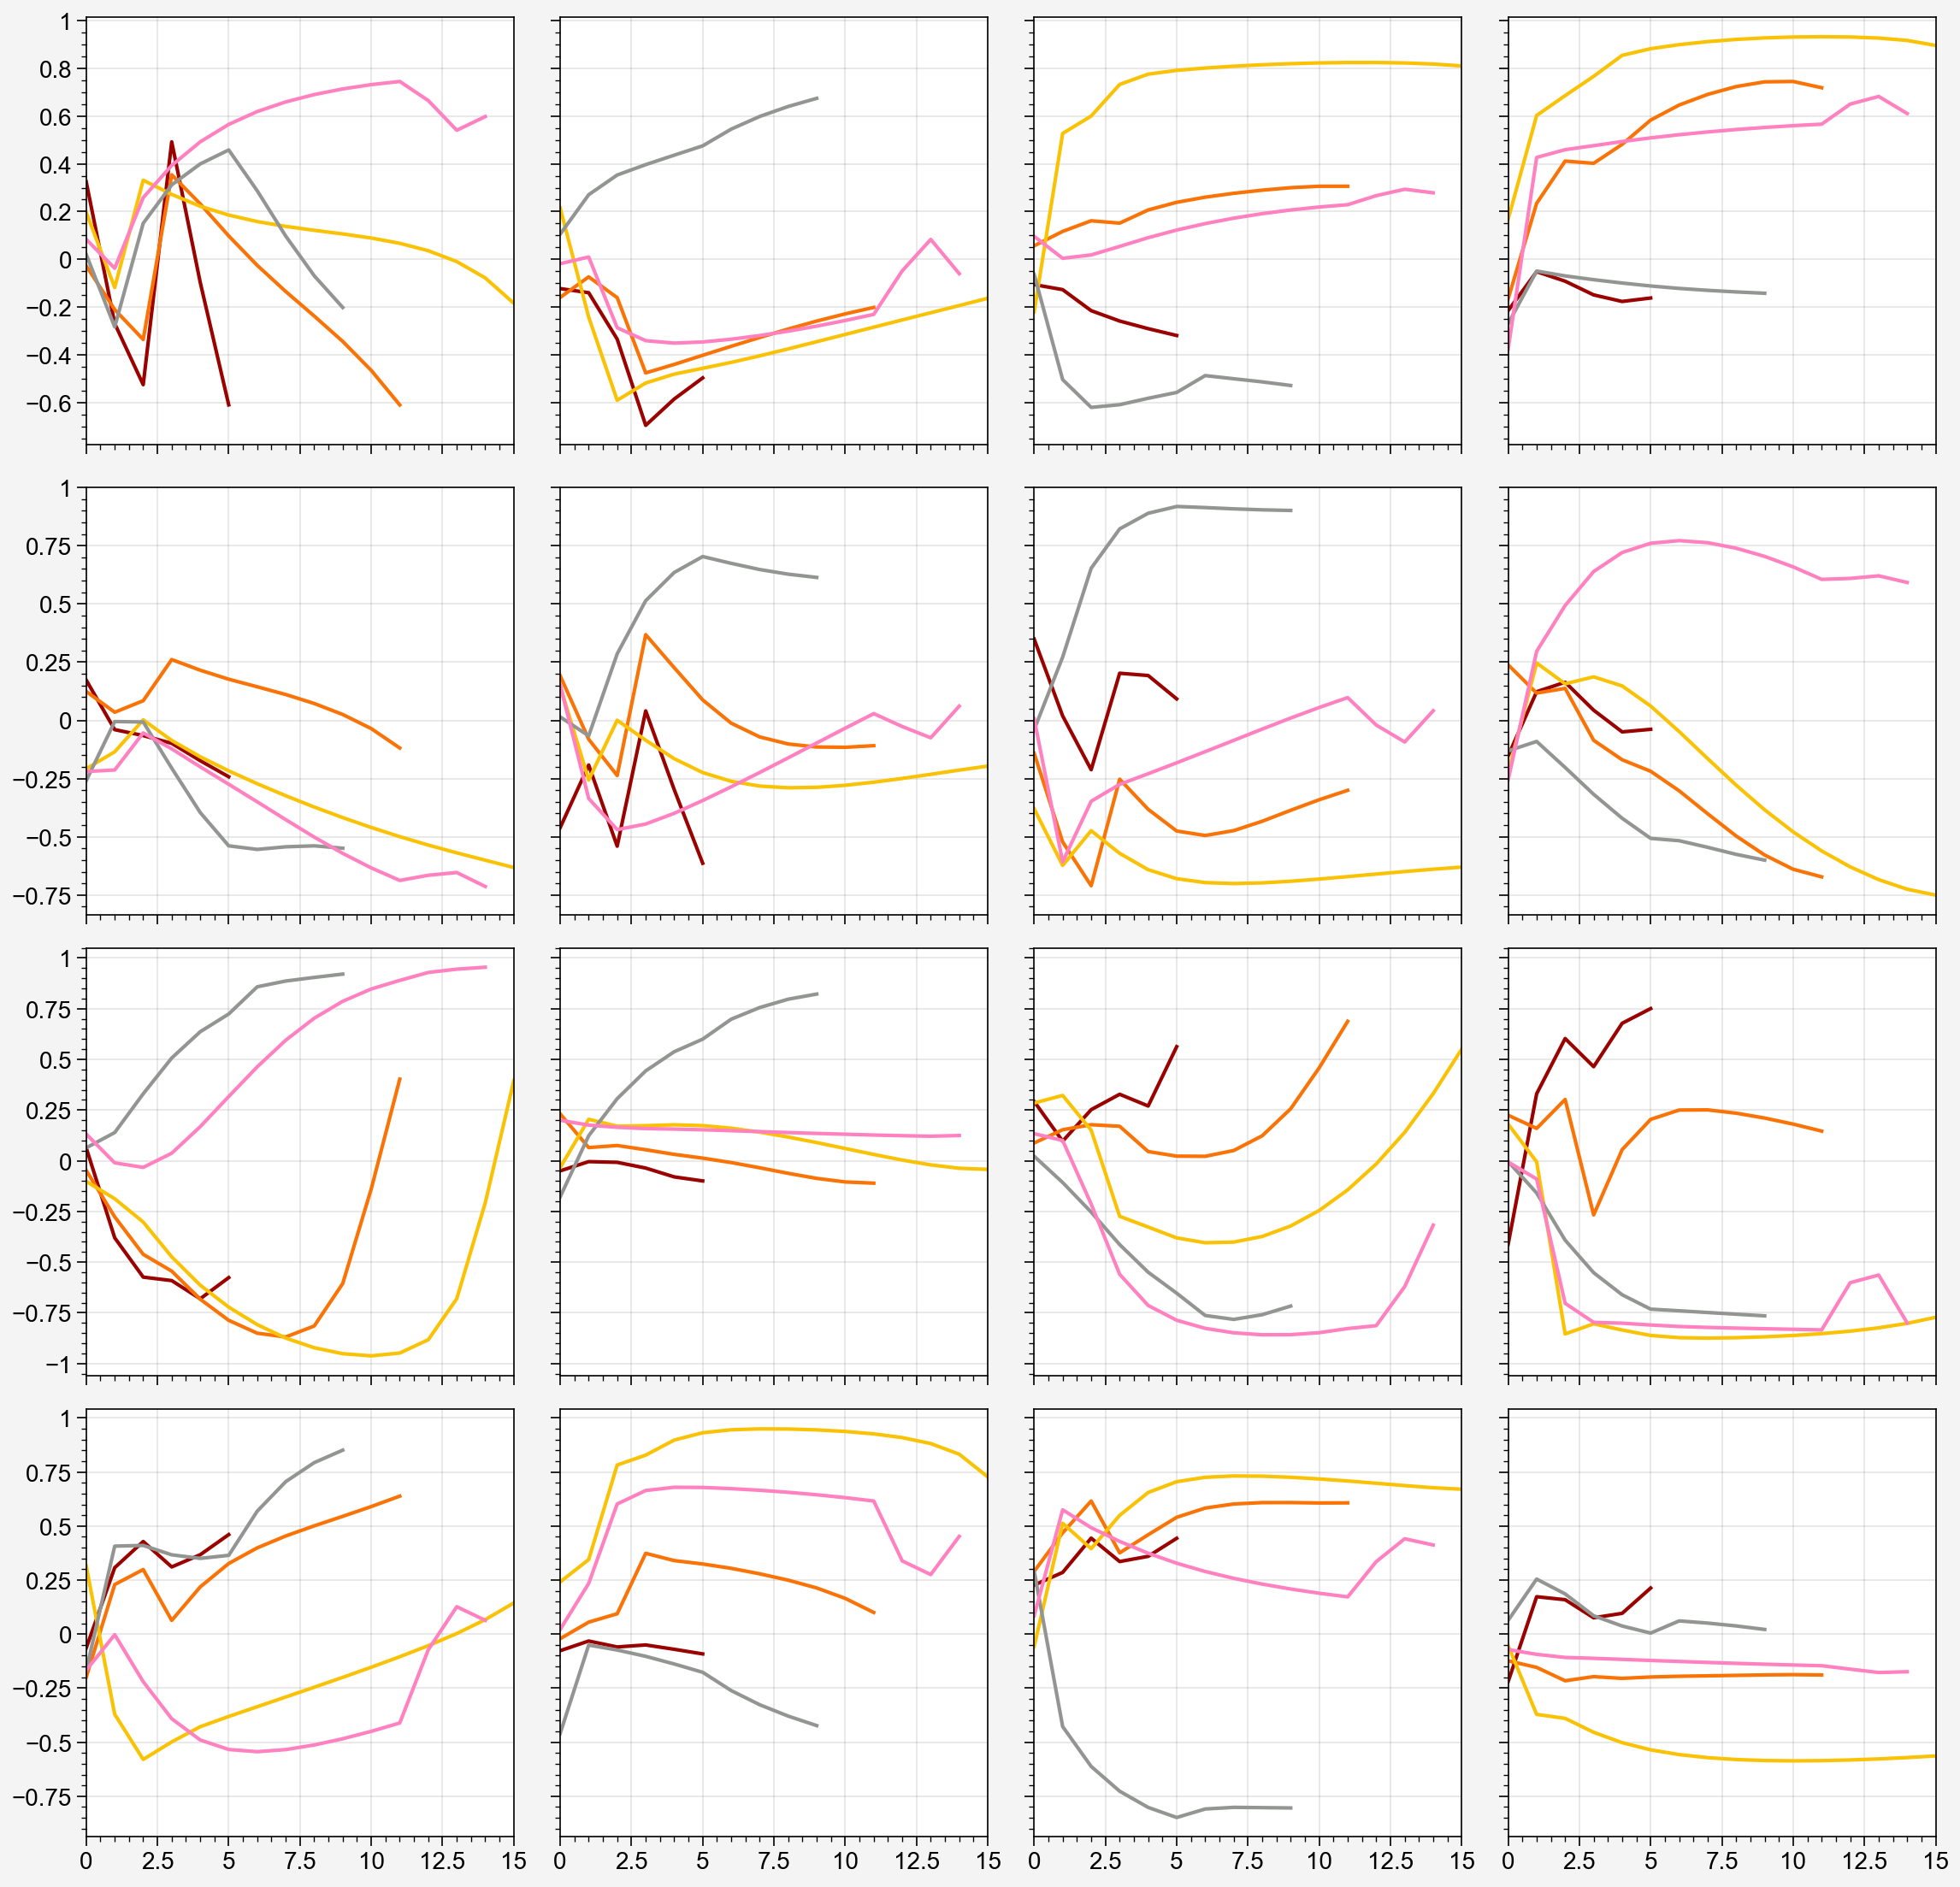

In [54]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    rnn_hxs = res['rnn_hxs'][i*5]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c=bart_plot_colors[i])


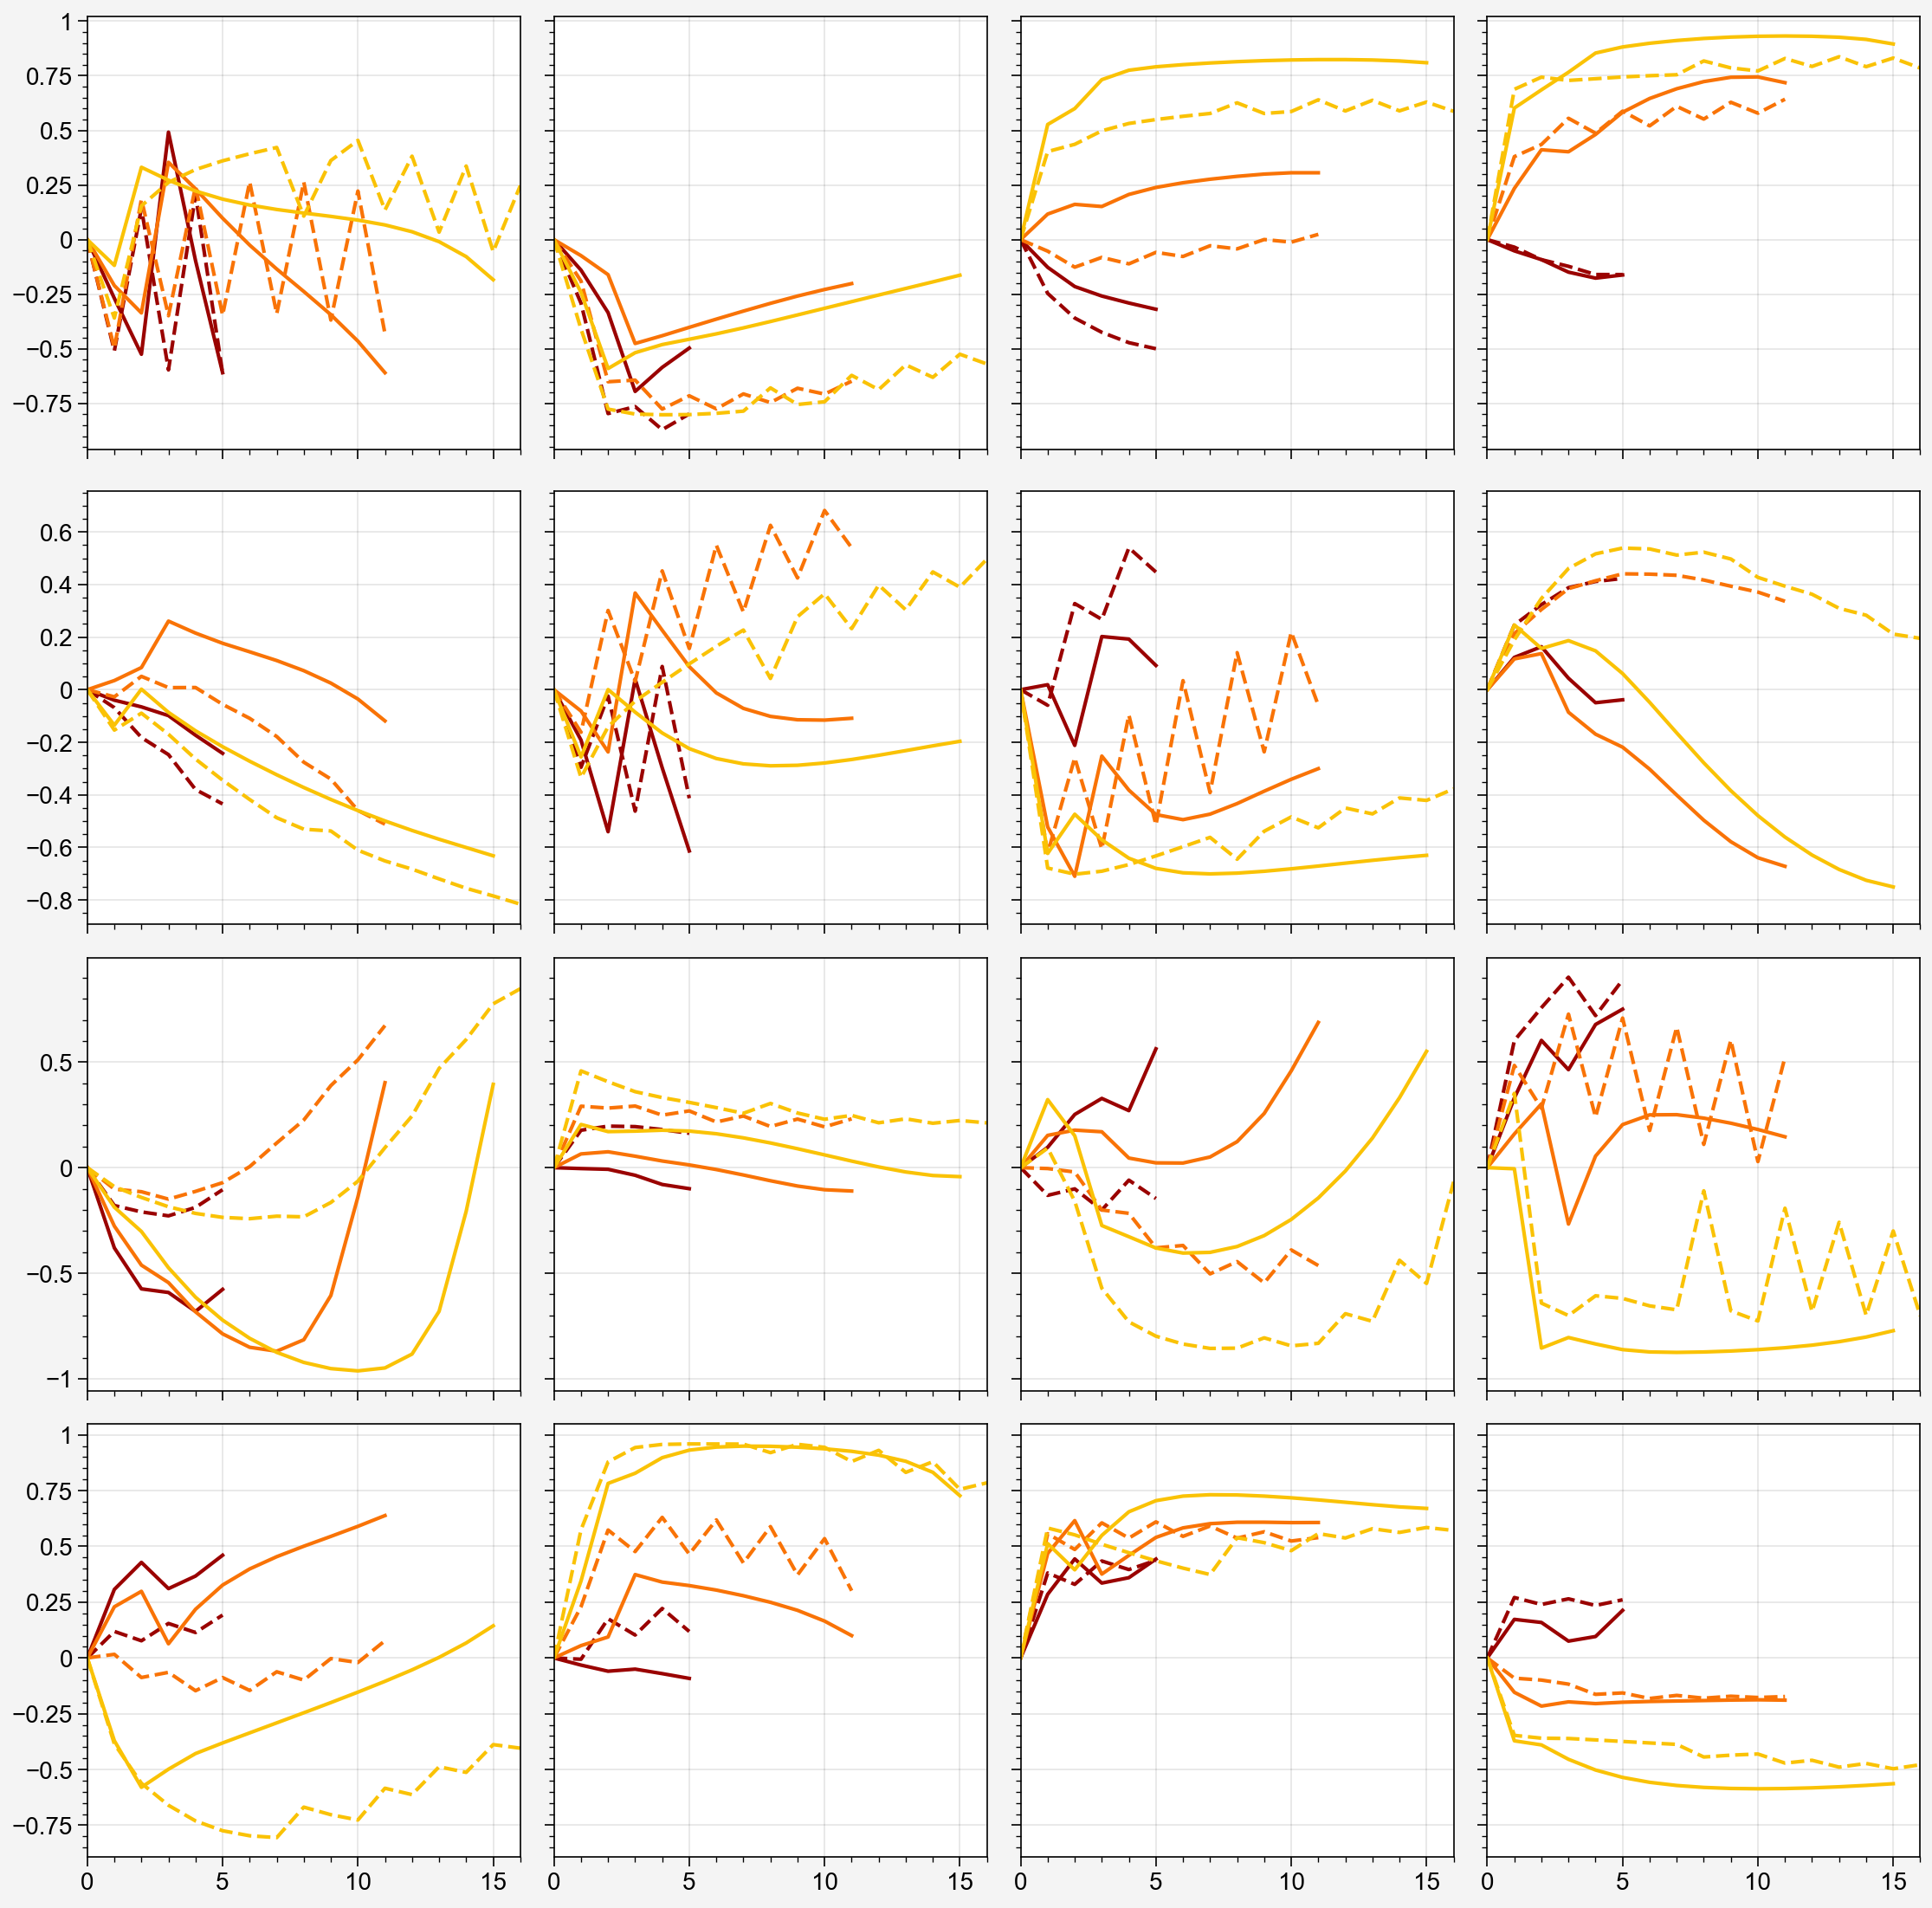

In [76]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(3):
    rnn_hxs = res['rnn_hxs'][i*5]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c=bart_plot_colors[i])
    rnn_hxs = res['rnn_hxs'][i*5+25]
    for j in range(16):
        ax[j].plot(rnn_hxs[:, j], c=bart_plot_colors[i], linestyle='--')


In [93]:
envs = res['envs']

In [98]:
np.round(envs.unnormalize_obs(res['obs'][10]), 3)

array([[ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.  ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.05, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.1 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.15,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.2 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.25,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.3 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.35,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.4 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.45,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.5 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.55,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.6 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  1.  , -0.  ,  0.  , -0.  ,  0.65,  1.  , 

In [101]:
np.round(envs.unnormalize_obs(res['obs'][20]), 3)

array([[ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.  ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.05, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.1 , -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.15, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.2 , -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.25, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.3 , -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.35, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.4 , -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.45, -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.5 , -0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.55,  1.  , -0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.6 ,  1.  , -0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  ,  1.  , -0.  ,  0.65, -0.  , 

In [88]:
res.keys()

dict_keys(['obs', 'actions', 'action_log_probs', 'action_probs', 'rewards', 'rnn_hxs', 'dones', 'masks', 'data', 'activations', 'values', 'actor_features', 'auxiliary_preds', 'auxiliary_truths'])

In [86]:
res['obs'][35][:15] - res['obs'][10]

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       , -2.2583044,  2.2583044],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       , -2.2583044,  2.2583044],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       , -2.2583044,  2.2583044],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       , -2.2583044,  2.2583044],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       , -2.2583044,  2.2583044],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         2.688867 ,  0.       ,  0.       ,  0.       ],


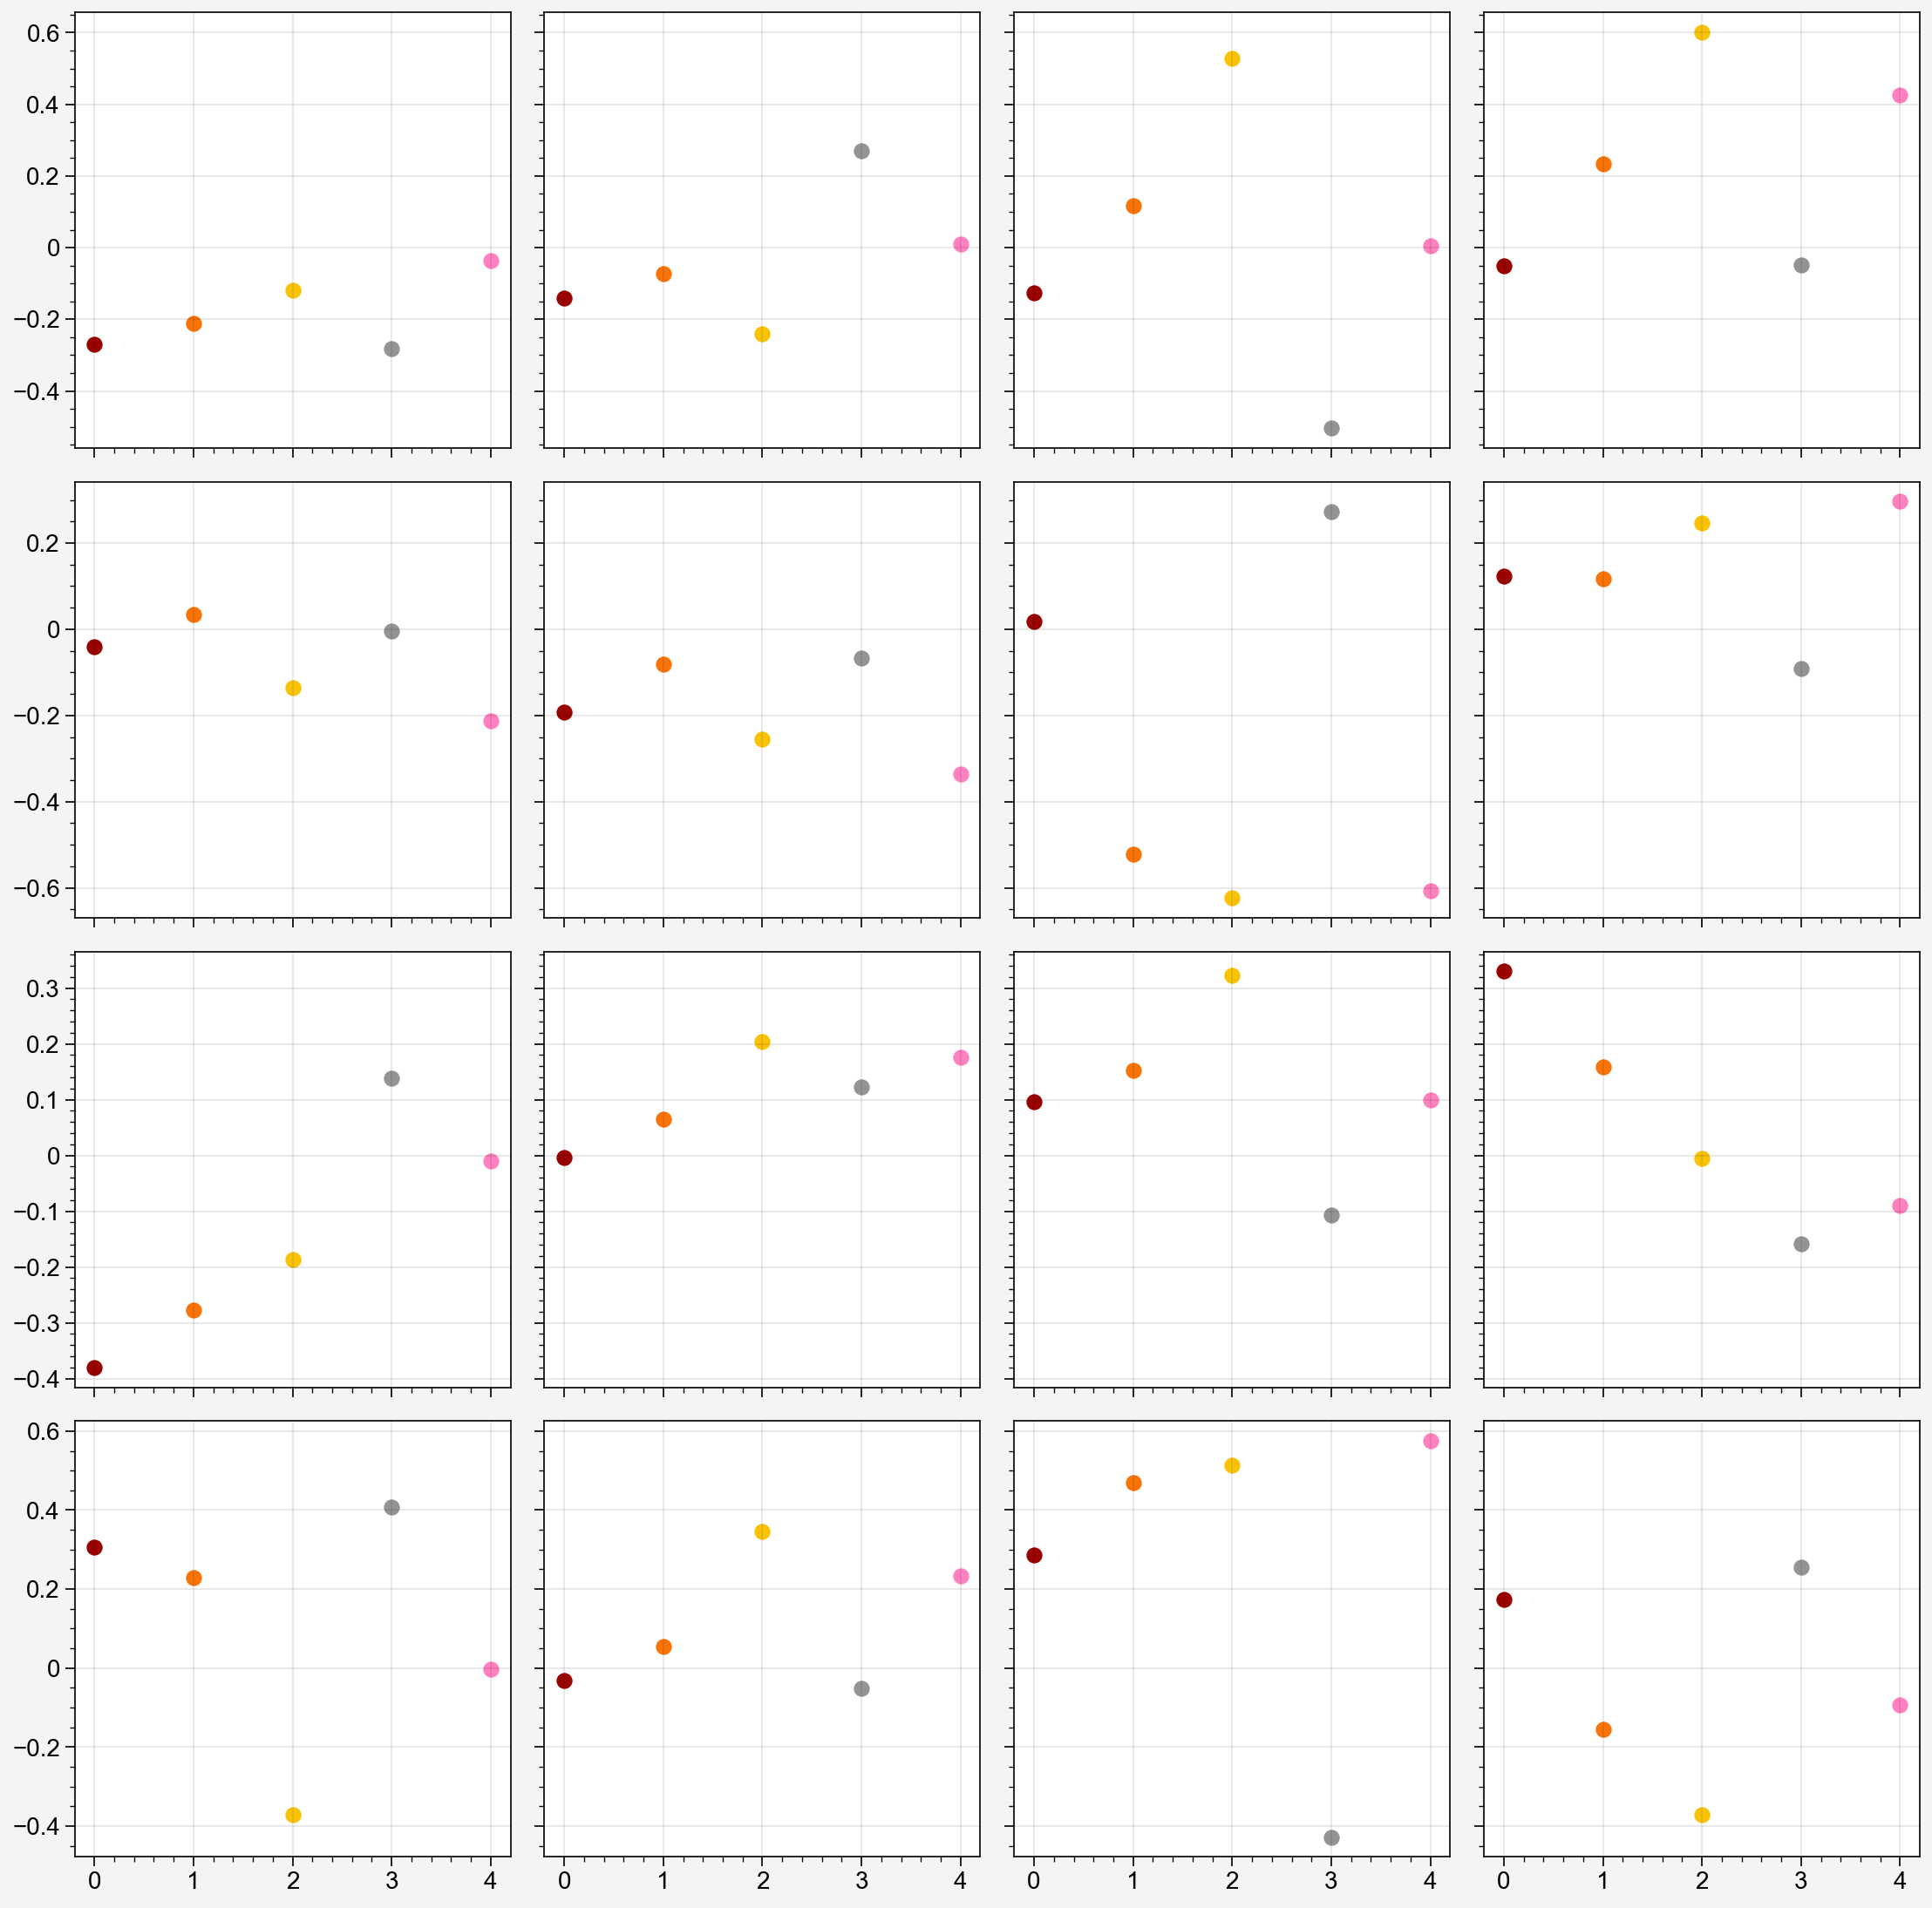

In [63]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    # for j in range(5):
    for j in [0]:
        for k in range(16):
            start_step = j+1
            r = res['rnn_hxs'][i*5+j][start_step, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])

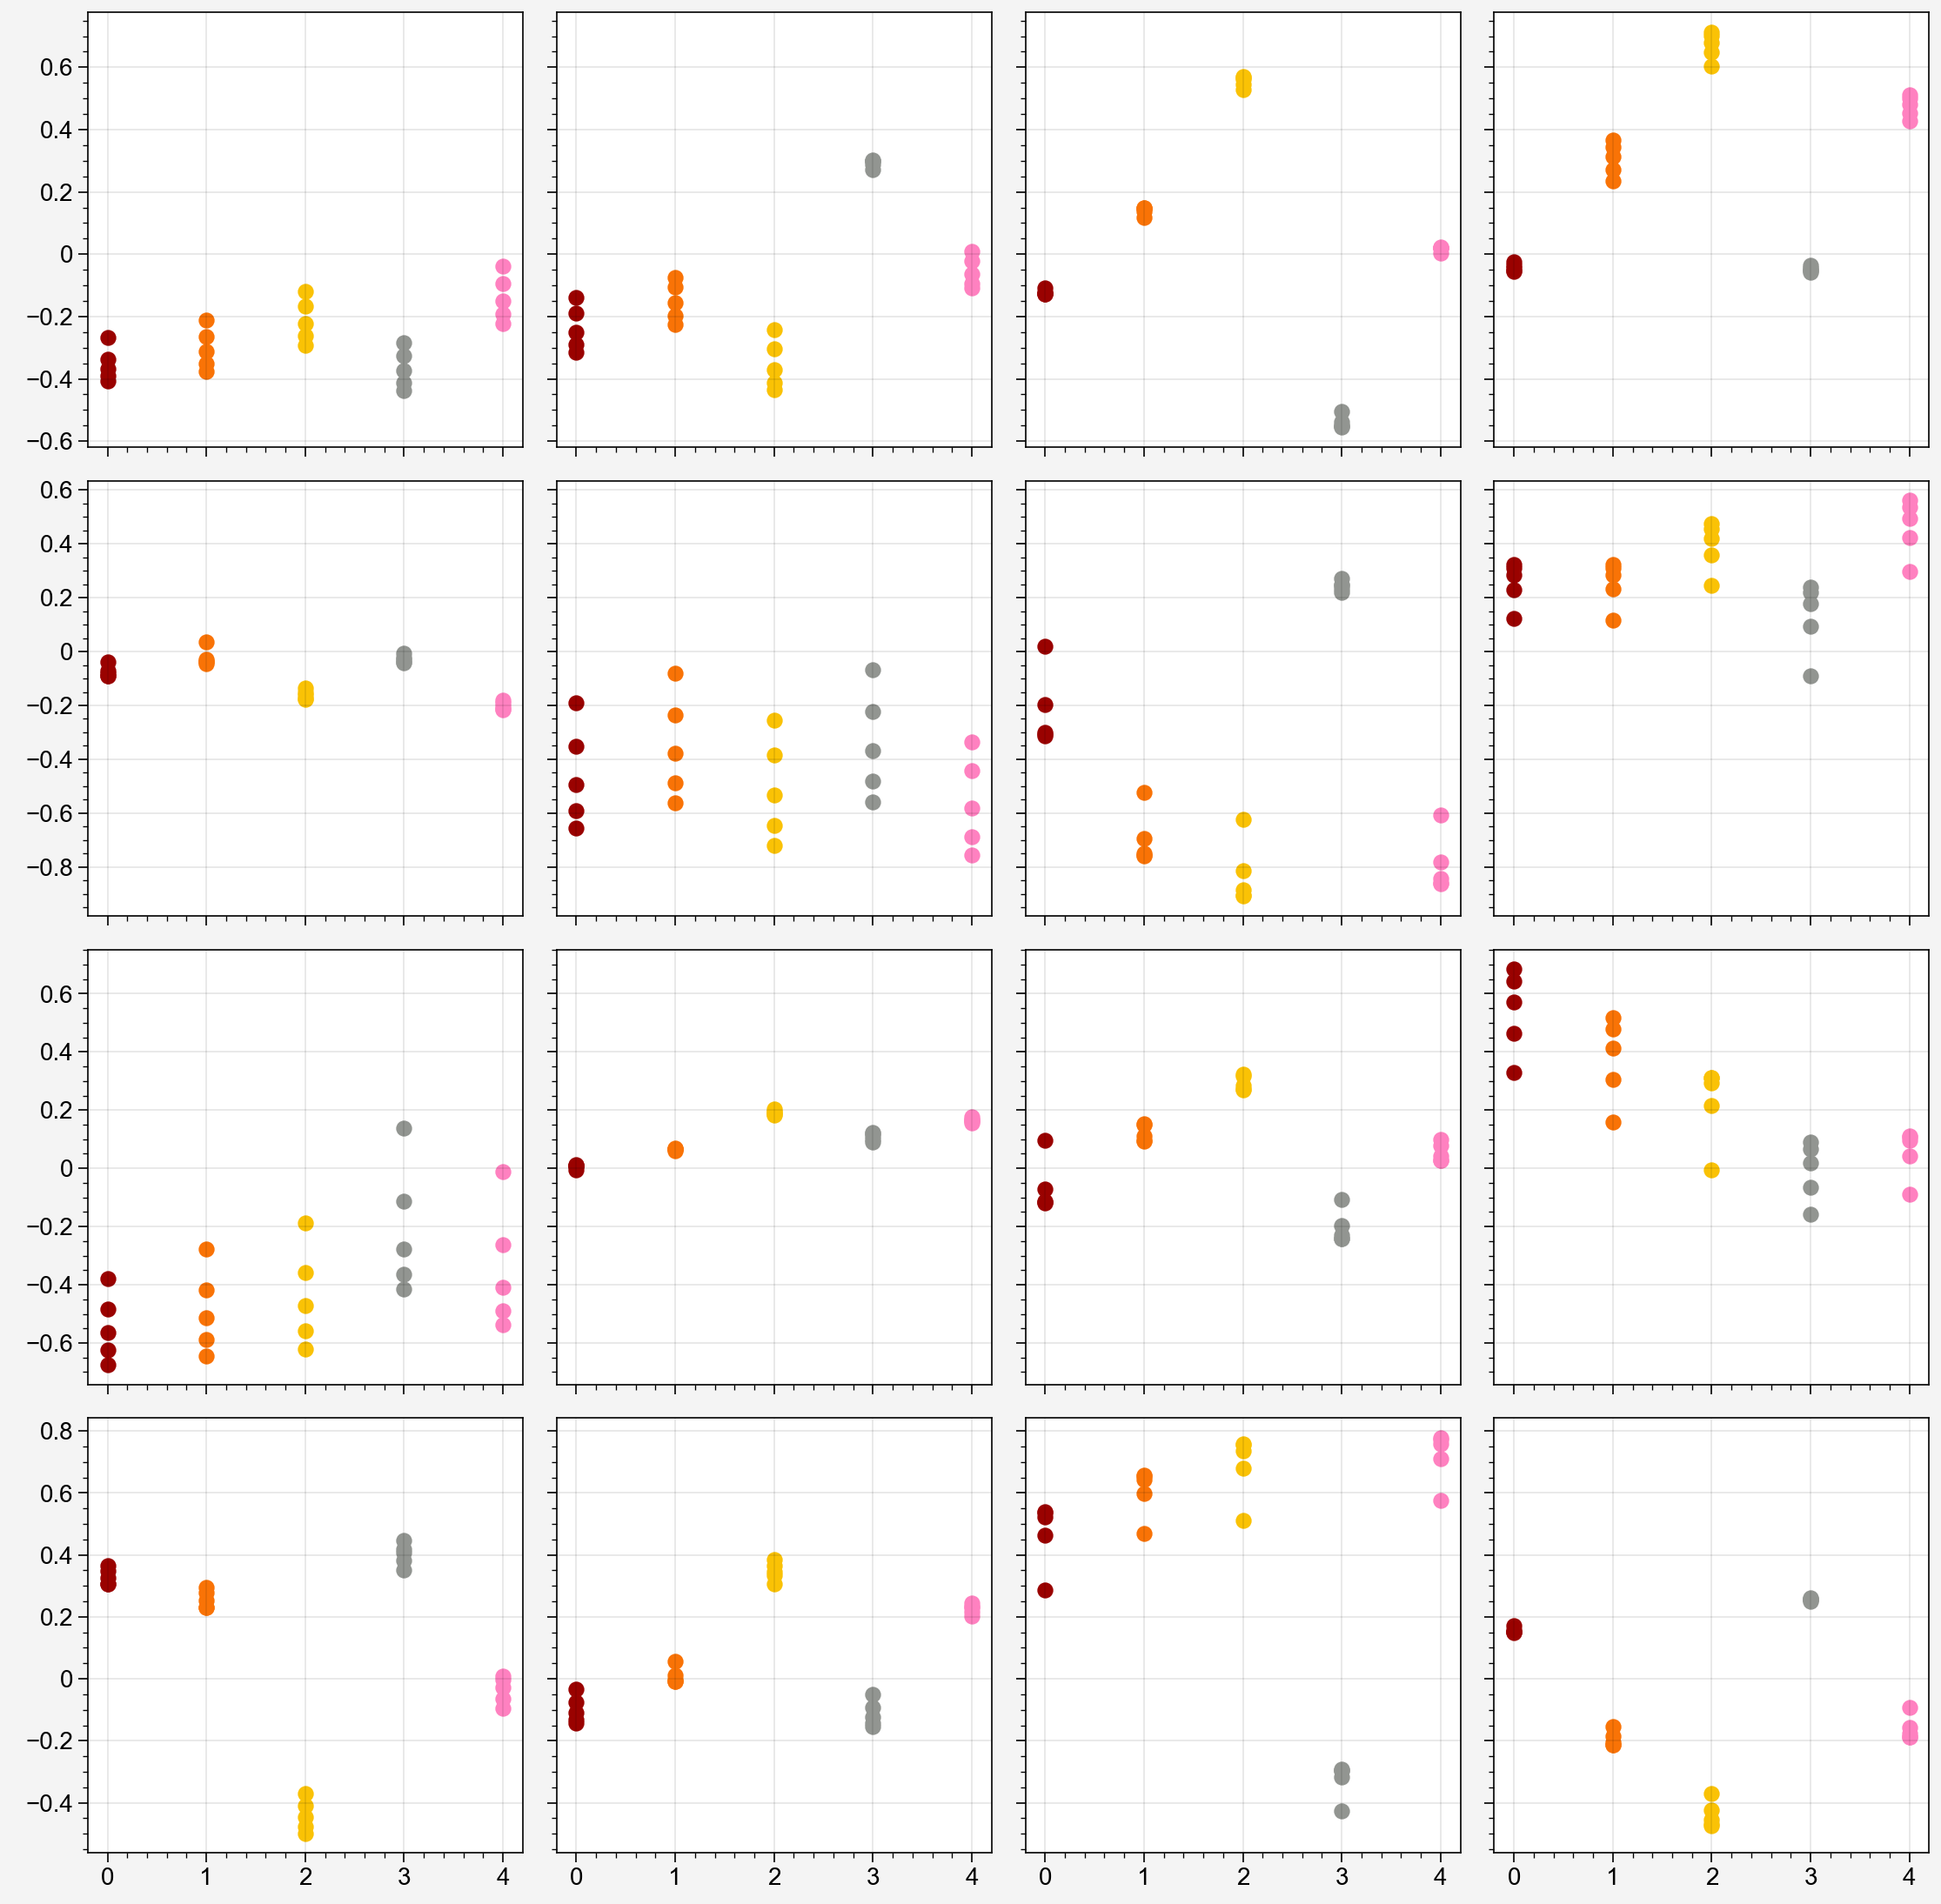

In [64]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    for j in range(5):
    # for j in [0]:
        for k in range(16):
            start_step = j+1
            r = res['rnn_hxs'][i*5+j][start_step, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])

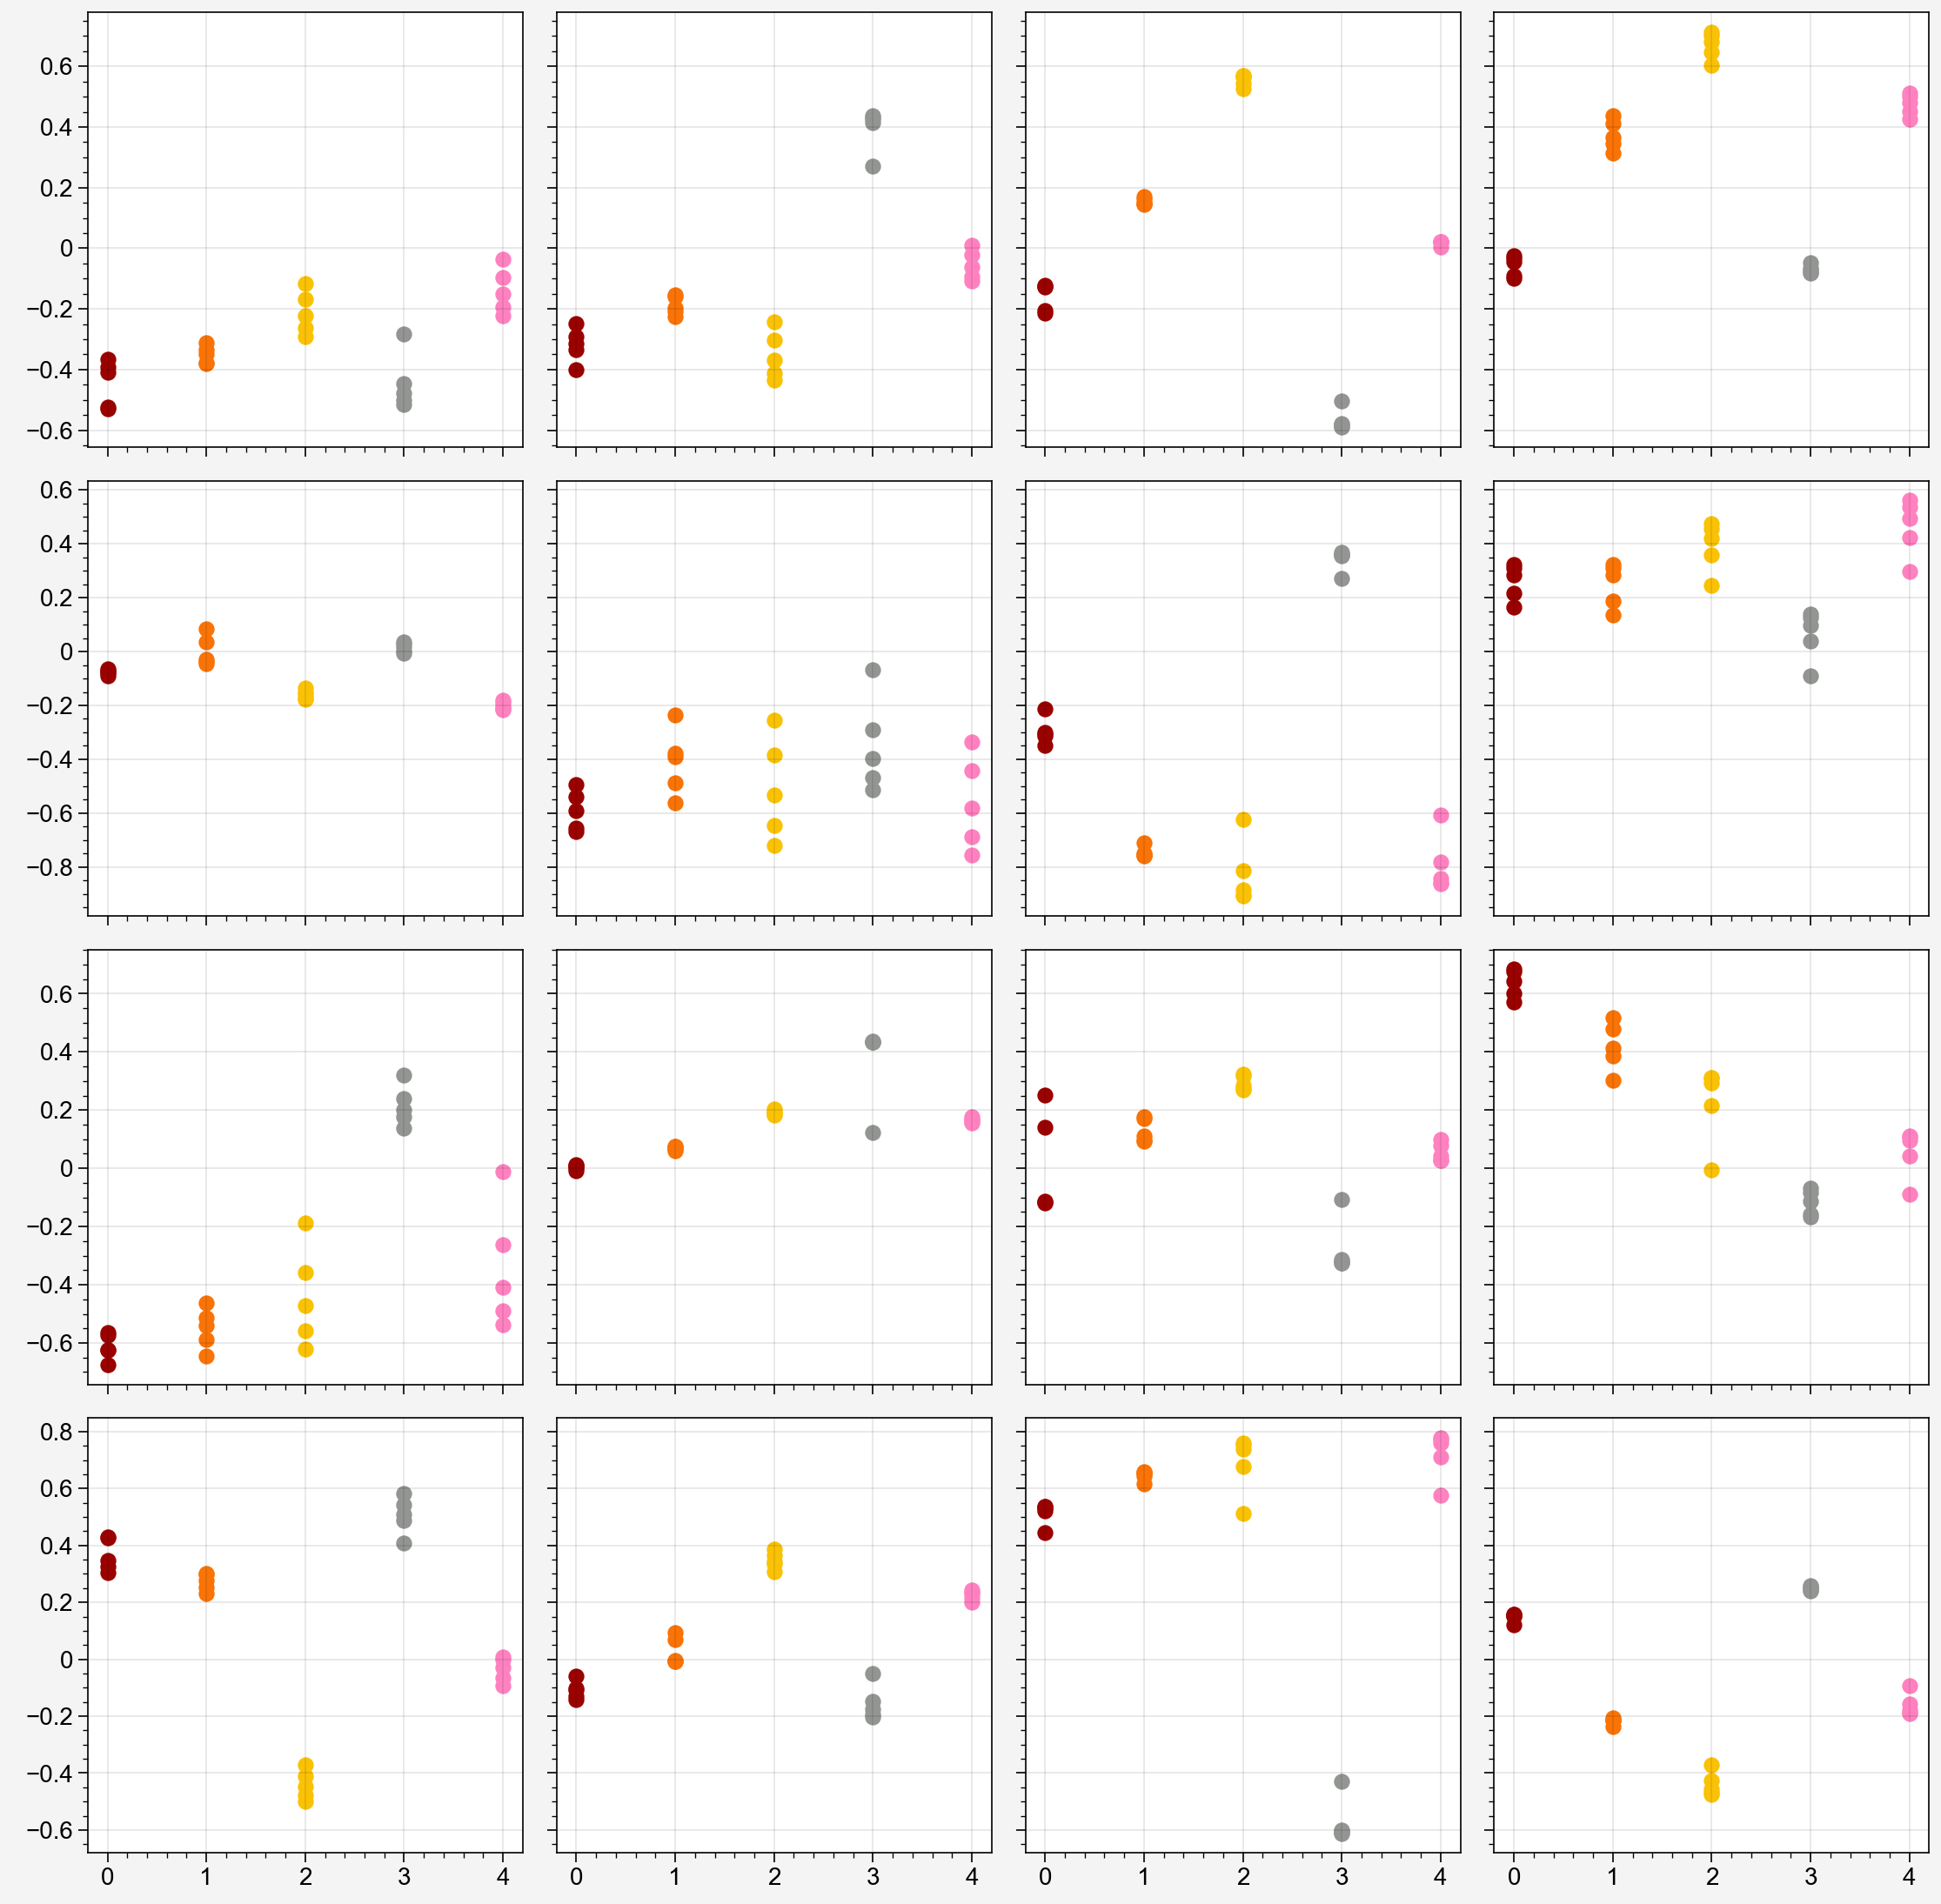

In [66]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    for j in range(5):
    # for j in [0]:
        for k in range(16):
            start_step = j+1+res['data']['inflate_delay'][i*5+j]
            r = res['rnn_hxs'][i*5+j][start_step, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])

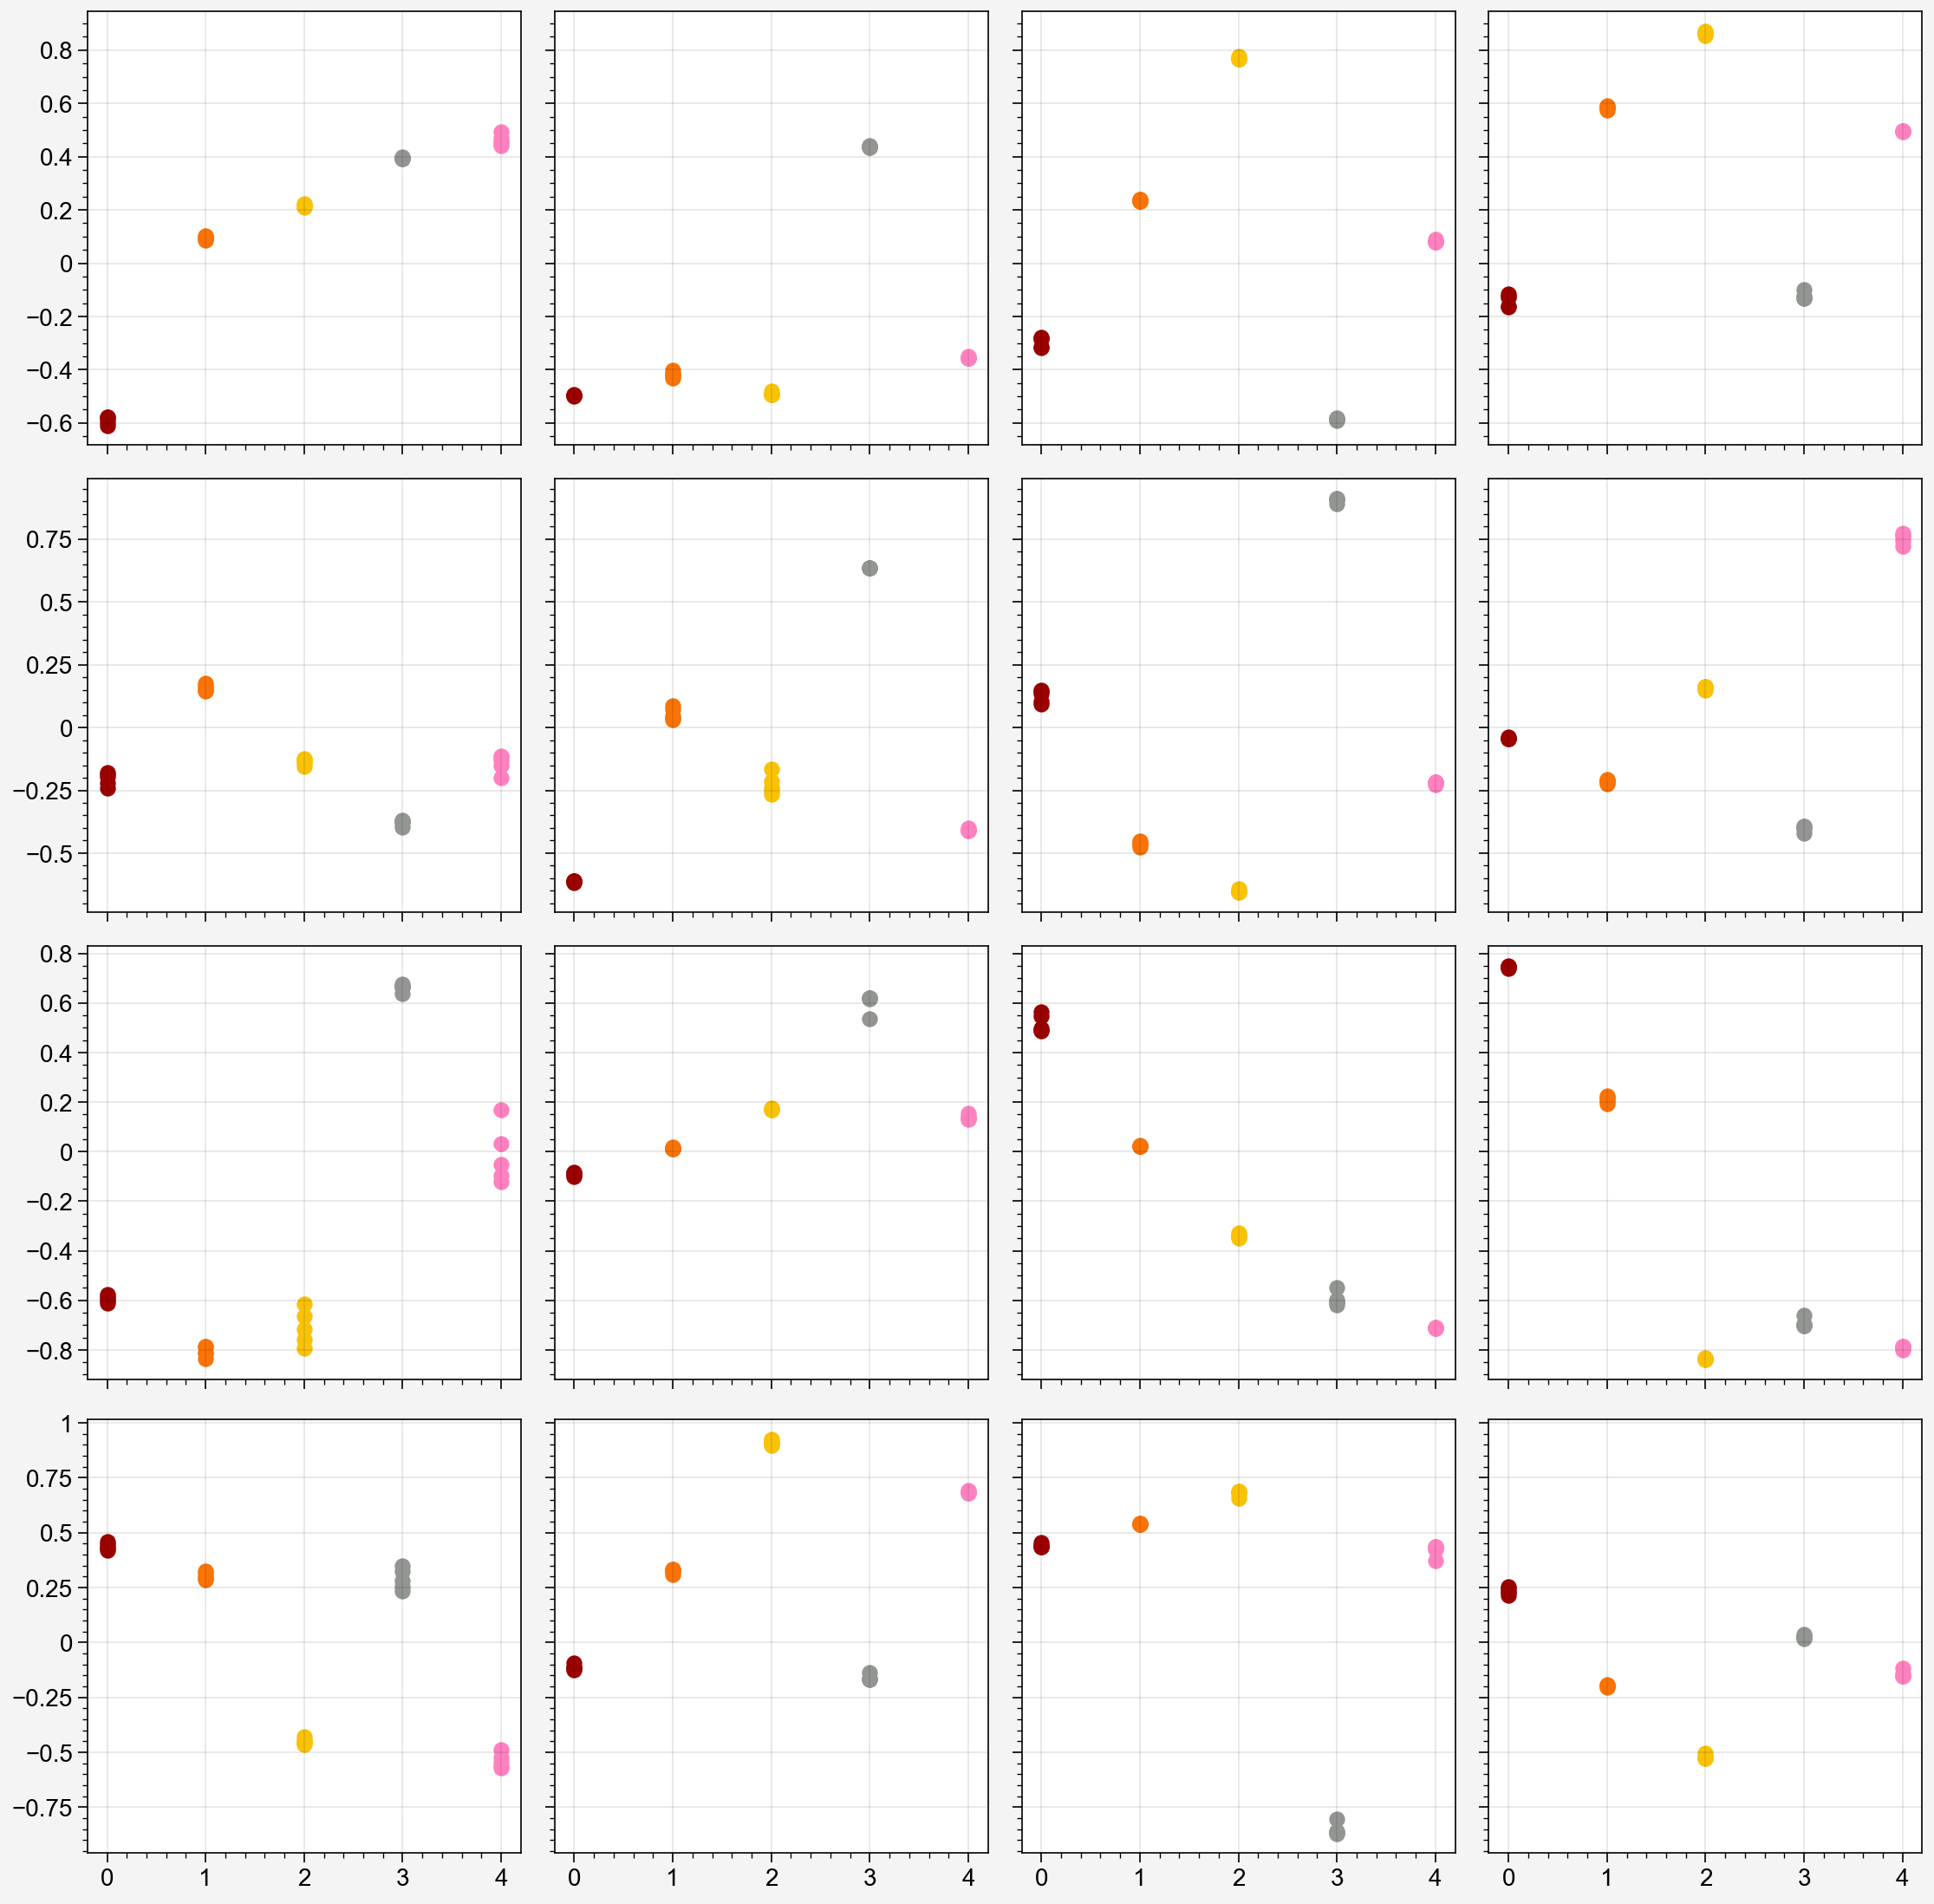

In [67]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    for j in range(5):
    # for j in [0]:
        for k in range(16):
            start_step = j+4+res['data']['inflate_delay'][i*5+j]
            r = res['rnn_hxs'][i*5+j][start_step, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])

In [65]:
res['data']['inflate_delay']

[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [ ]:
fig, ax = pplt.subplots(nrows=4, ncols=4)
for i in range(5):
    # for j in range(5):
    for j in [0]:
        for k in range(16):
            start_step = j
            r = res['rnn_hxs'][i*5+j][j, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])

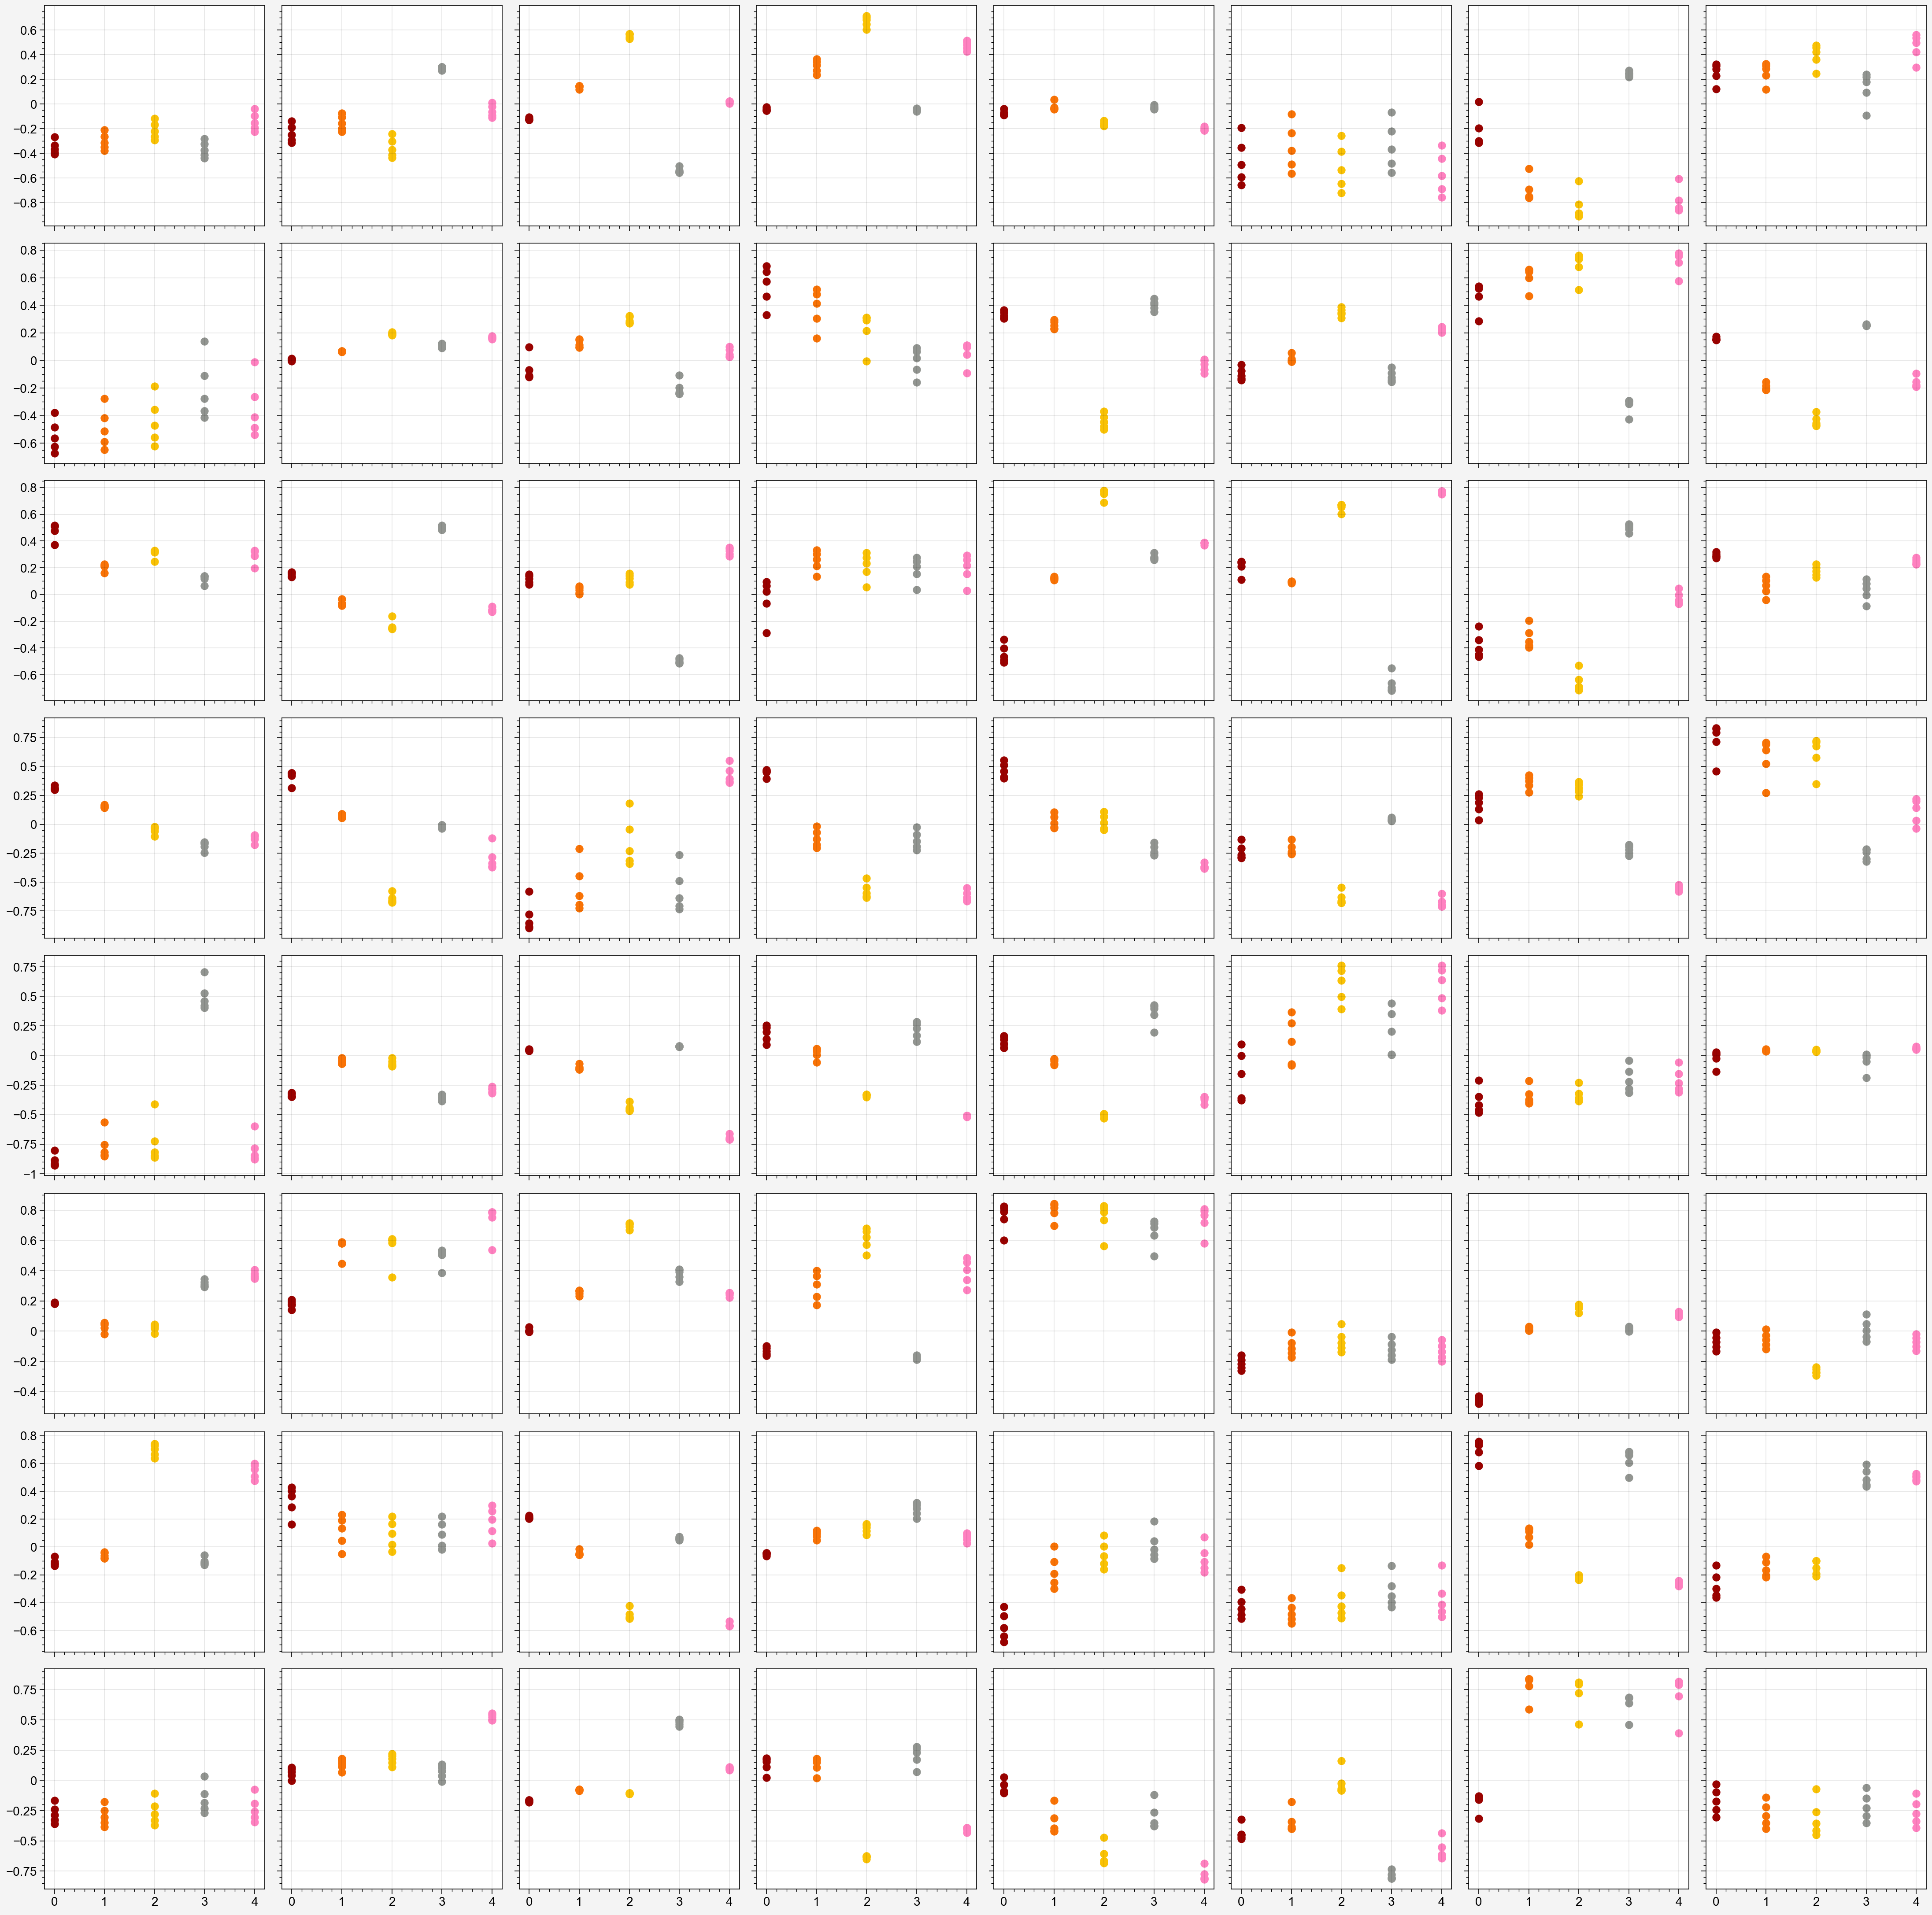

In [69]:
fig, ax = pplt.subplots(nrows=8, ncols=8)
for i in range(5):
    for j in range(5):
        for k in range(64):
            start_step = j+1
            r = res['rnn_hxs'][i*5+j][start_step, k]
            ax[k].scatter(i, r, c=bart_plot_colors[i])